## Vanilla MobileNetV2 Implementation

**AIM: Build and train an image classifier to detect images from different animal species using a Custom MobileNet Model in TensorFlow.**

### Objectives

- Data visualisation
- Data preprocessing and image augmentation
- Replicate the ResNet-34 architecture for model development.
- Compile and train the model
- Add early stopping callback (optional
- Save and load the model
- Model evaluation.
- Make predictions on new data using the trained model.

### Pre-requisite
- Google collaboratry or Jupyter Notebook
- animal-image-classification-dataset
- TensorFlow2

In [1]:
# Import basic libraries
import os
import sys
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

2026-01-31 13:58:26.329609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769864306.343149   14094 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769864306.347497   14094 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769864306.357276   14094 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769864306.357294   14094 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769864306.357295   14094 computation_placer.cc:177] computation placer alr

In [2]:
# Set seed for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Check GPU availability
!nvidia-smi

Sat Jan 31 13:58:27 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              6W /  110W |    7563MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
gpus= tf.config.list_physical_devices()

In [5]:

gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
logical_devices = tf.config.list_logical_devices()
logical_devices

I0000 00:00:1769864308.651517   14094 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 120 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [7]:
# Check tenorflow version
print("TensorFlow Version", tf.__version__)

TensorFlow Version 2.19.0


In [8]:
## Set the base path
base_dir = "../dataset/animal_image_classification_dataset"
base_dir = pathlib.Path(base_dir)
base_dir

PosixPath('../dataset/animal_image_classification_dataset')

In [9]:
# Train directory
train_dir = base_dir / "Training Data" / "Training Data"
train_dir

PosixPath('../dataset/animal_image_classification_dataset/Training Data/Training Data')

In [10]:
# Validation directory
validation_dir = base_dir / "Validation Data" / "Validation Data"
validation_dir

PosixPath('../dataset/animal_image_classification_dataset/Validation Data/Validation Data')

In [11]:
## Set Hyperparameters

IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
BATCH_SIZE = 64
EPOCHS = 300

In [12]:
# Load the training dataset

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
)

Found 30000 files belonging to 15 classes.


I0000 00:00:1769864311.428193   14094 cuda_executor.cc:479] failed to allocate 120.50MiB (126353408 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [13]:
# Load the validation dataset

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
)

Found 2000 files belonging to 15 classes.


In [14]:
# Get the class names
class_names = train_dataset.class_names
class_names

['Beetle',
 'Butterfly',
 'Cat',
 'Cow',
 'Dog',
 'Elephant',
 'Gorilla',
 'Hippo',
 'Lizard',
 'Monkey',
 'Mouse',
 'Panda',
 'Spider',
 'Tiger',
 'Zebra']

In [15]:
# Get the total number of classes
num_classes = len(class_names)
num_classes

15

2026-01-31 13:58:33.311621: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


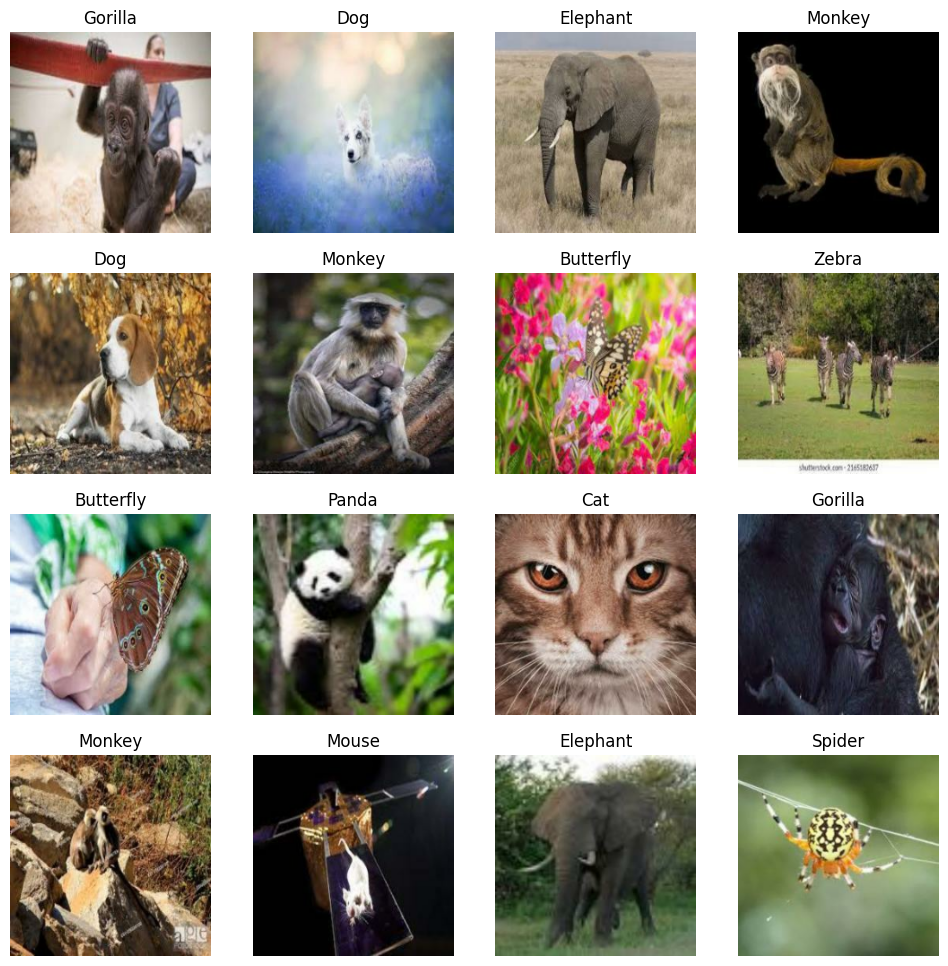

In [16]:
# Sanity check

for images, labels in train_dataset.take(1):
    fixed_images = images.numpy()
    fixed_labels = labels.numpy()


# Visualisations
# No matter how many times you run this cell, the images won change because of teh above

plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fixed_images[i].astype("uint8"))
    plt.title(class_names[fixed_labels[i]])
    plt.axis("off")

In [17]:
# Performance optimization

### Vanilla MobileNetV2 Implementation

In [18]:
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3, )
INPUT_SHAPE

(224, 224, 3)

In [19]:
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

# STEM CONVOLUTION (Initial Layer)
x = tf.keras.layers.Conv2D(filters=32,
                                kernel_size=(3, 3),
                                strides=2,
                                padding="same",
                                use_bias=False)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

# BLOCK 1 (Expansion = 1)
block_input = x

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                    strides=1,
                                    padding="same",
                                    use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.Conv2D(filters=16,
                           kernel_size=1,
                           padding="same",
                           use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)

# NOTE: No residual here because channel mismatch


# BLOCK 2 (Expansion = 6, Stride = 2)
block_input = x

x = tf.keras.layers.Conv2D(filters=16*6,
                           kernel_size=(1, 1),
                           padding="same",
                           use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                    strides=2,
                                    padding="same",
                                    use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.Conv2D(filters=24,
                           kernel_size=1,
                           padding="same",
                           use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)


# BLOCK 3 (Expansion = 6, Stride = 1, Residual)
block_input = x

x = tf.keras.layers.Conv2D(filters=24*6,
                           kernel_size=(1, 1),
                           padding="same",
                           use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                    strides=1,
                                    padding="same",
                                    use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.Conv2D(filters=24,
                           kernel_size=1,
                           padding="same",
                           use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([block_input, x])


# BLOCK 4 (Expansion = 6, Stride = 2)
block_input = x

x = tf.keras.layers.Conv2D(filters=24*6,
                           kernel_size=(1, 1),
                           padding="same",
                           use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                    strides=2,
                                    padding="same",
                                    use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.Conv2D(filters=32,
                           kernel_size=1,
                           padding="same",
                           use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)


# BLOCK 5 (Expansion = 6, Residual)
block_input = x

x = tf.keras.layers.Conv2D(filters=32*6,
                           kernel_size=(1, 1),
                           padding="same",
                           use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                                    strides=1,
                                    padding="same",
                                    use_bias=False)(block_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)

x = tf.keras.layers.Conv2D(filters=32,
                           kernel_size=1,
                           padding="same",
                           use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Add()([block_input, x])


# Final Conv Layer
x = tf.keras.layers.Conv2D(filters=1280,
                           kernel_size=1,
                           padding="same",
                           use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(max_value=6)(x)


# Classification Head

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        288 │ re_lu[0][0]       │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │        512 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 56, 56,    │        144 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │        384 │ re_lu_3[0][0]     │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 56, 56,    │        216 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         96 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 71,727 (280.18 KB)

 Trainable params: 68,591 (267.93 KB)

 Non-trainable params: 3,136 (12.25 KB)

In [20]:
# Compile Model
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [21]:
# Configure Callbacks

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/vanilla_mobilenet_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    factor=0.3,
    verbose=1
)

callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]


In [22]:
# Train the Model to learn patterns from the image

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/300


I0000 00:00:1769864319.865759   14184 service.cc:152] XLA service 0x78aa04023c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769864319.865888   14184 service.cc:160]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2026-01-31 13:58:40.005363: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1769864320.591969   14184 cuda_dnn.cc:529] Loaded cuDNN version 90501
E0000 00:00:1769864320.810384   14184 cuda_blas.cc:193] failed to create cublas handle: the resource allocation failed
E0000 00:00:1769864320.810421   14184 cuda_blas.cc:196] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machi

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_14094/260707798.py", line 3, in <module>

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 399, in fit

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 241, in function

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in multi_step_on_iterator

  File "/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.28 = (f32[64,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,225,225]{3,2,1,0} %bitcast.8931, f32[32,3,3,3]{3,2,1,0} %bitcast.8938), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16780672 bytes. [tf-allocator-allocation-error='']

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_8399]

In [ ]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))


    plt.figure(figsize=(18, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


In [ ]:
loss, accuracy = model.evaluate(validation_dataset)

print(f"Model Loss: {loss:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5580 - loss: 1.3565
Model Loss: 1.36
Model Accuracy: 0.56
